<a href="https://colab.research.google.com/github/braveenth/garmin-running-llm/blob/main/Garmin_Running_LLM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garmin Running LLM Analysis 🏃
By: Braveenth Rasanayagam

---

The goal of this Jupyter Notebook is to have reuseable code that facilitates the prompting and analysis of your your Garmin-tracked runs by LLMs.

This was built to help train for a half-marathon, and you can use it for your fitness activities.

I solved the context length limitations imposed by various LLM models by splitting the data using even rows, which is a method to reduce the number of data points. I am also considering other mathematical methods of reducing the number of data points.

Please note that I am not responsible or liable for your use of this application. Please use this at your own risk and consult with a health care professional.


## Steps to Use:
Using OpenAI's ChatGPT API:

1.   Obtain an OpenAI API Key here: https://platform.openai.com/api-keys
2.   Add OpenAI API Key as a Colab secret value named 'OPENAI_API_KEY'
3.   Obtain .fit file from Garmin Connect
4.   Upload .fit file to Colab files
5.   Specify path to .fit file in notebook form

## Steps to Contribute:
Submit a pull-request or message me!
MIT License

## Additional Links
*   [runw.ai](https://www.runw.ai/)
*   [Instagram - runw.ai](https://www.instagram.com/runw.ai.run/)


In [ ]:
!pip install garmin-fit-sdk
!pip install tiktoken
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.5/234.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00


In [ ]:
# Lets start by obtaining the path to the .fit file
fit_file = "/content/14426903567_ACTIVITY.fit" # @param {type:"string"}

In [ ]:
# This is for when the program runs outside of Colab

import os
colabEnvironment = False

try:
    # Attempt to import the google.colab module to see if the program is running in Colab.
    from google.colab import userdata
    print("Running on Google Colab")
    colabEnvironment = True
    openai_api_key = userdata.get('OPENAI_API_KEY')
    client = OpenAI(api_key=openai_api_key)

except ImportError:
    # The ImportError exception will be raised if the google.colab module is not found,
    # indicating that the program is not running inside Google Colab.
    print("Running outside of Google Colab")
    from openai import OpenAI
    openai_api_key = os.environ.get('OPENAI_API_KEY')
    if openai_api_key is None:
        raise Exception("OPENAI_API_KEY environment variable not set")
    client = OpenAI(api_key=openai_api_key)
    fit_file = os.environ.get('FIT_FILE_PATH')

In [ ]:
# Lets describe an existing run that I have completed. We will use the fit file from Garmin Connect.
# In the future, we will retrieve this using Garmin's API.
# Lets use the garmin-fit-sdk here

from garmin_fit_sdk import Decoder, Stream

stream = Stream.from_file(fit_file)
decoder = Decoder(stream)
messages, errors = decoder.read()

print(errors)
# print(messages)

[]


In [ ]:
file_messages = messages['file_id_mesgs']

duration_of_activity = messages['activity_mesgs'][0]['total_timer_time']
activity_record_messages = messages['record_mesgs']

# for activity_message in activity_record_messages:
#   print(activity_message)
#print(messages['user_profile_mesgs'])
#print(messages['file_id_mesgs'])

# Information about the units
# 'distance' - metres

In [ ]:
# Lets get this information into a Pandas Dataframe

import pandas as pd

df = pd.DataFrame(activity_record_messages)
# Lets remove columns that are currently not necessary

df_with_relevant_information = df.drop(['cycle_length16', 'enhanced_speed','fractional_cadence', 135, 136], axis=1)
display(df_with_relevant_information)

,timestamp,distance,heart_rate,cadence,temperature
0,2024-03-15 20:41:55+00:00,0.00,117,0,29
1,2024-03-15 20:41:58+00:00,0.00,121,0,29
2,2024-03-15 20:41:59+00:00,0.00,125,0,29
3,2024-03-15 20:42:00+00:00,0.00,129,0,29
4,2024-03-15 20:42:02+00:00,0.00,134,0,29
...,...,...,...,...,...
564,2024-03-15 21:34:43+00:00,5721.30,143,49,29
565,2024-03-15 21:34:49+00:00,5727.37,143,50,29
566,2024-03-15 21:34:55+00:00,5733.64,142,52,29
567,2024-03-15 21:35:01+00:00,5740.00,140,50,29


In [ ]:
# Lets use the timestamp to get additional information

df2 = df_with_relevant_information

startDateTime = df.iloc[0]['timestamp']
endDateTime = df.iloc[-1]['timestamp']
print(startDateTime)
print(endDateTime)

time_diff = endDateTime - startDateTime
print(time_diff)
#df2['Time (min)'] = df2['timestamp']
#df2['Pace (min/km)'] = df2['Time (min)'] / df2['Distance (km)']

df2['seconds'] = df['timestamp'].astype('int64') // 1e9

specific_value3 = df2.loc[0, 'seconds']
print(specific_value3)
df2['activity_duration_seconds'] = df2['seconds'] - specific_value3


#display(df2)

df_original = df2.drop(['timestamp', 'seconds'], axis=1)
#display(df3)


2024-03-15 20:41:55+00:00
2024-03-15 21:35:03+00:00
0 days 00:53:08
1710535315.0


In [ ]:
# Lets calculate Derivatives here
import numpy as np

# 1. Distance and Speed
#    First Derivative (Velocity)
df_original['velocity'] = np.gradient(df_original['distance'], df_original['activity_duration_seconds'])

#    Second Derivative (Acceleration)
df_original['acceleration'] = np.gradient(df_original['velocity'], df_original['activity_duration_seconds'])


# 2. Heart Rate Dynamics
#    First Derivative
df_original['heart_rate_dynamics'] = np.gradient(df_original['heart_rate'], df_original['activity_duration_seconds'])


# 3. Cadence Variability
#    First Derivative
df_original['cadence_variability'] = np.gradient(df_original['cadence'], df_original['activity_duration_seconds'])


# 4. Temperature Effects
#    First Derivative
df_original['temperature_effects'] = np.gradient(df_original['temperature'], df_original['activity_duration_seconds'])


display(df_original)

,distance,heart_rate,cadence,temperature,activity_duration_seconds,velocity,acceleration,heart_rate_dynamics,cadence_variability,temperature_effects
0,0.00,117,0,29,0.0,0.000000,0.000000,1.333333,0.000000,0.000000e+00
1,0.00,121,0,29,3.0,0.000000,0.000000,3.333333,0.000000,0.000000e+00
2,0.00,125,0,29,4.0,0.000000,0.000000,4.000000,0.000000,0.000000e+00
3,0.00,129,0,29,5.0,0.000000,0.000000,3.500000,0.000000,8.881784e-16
4,0.00,134,0,29,7.0,0.000000,0.000000,2.833333,45.333333,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
564,5721.30,143,49,29,3168.0,0.991667,0.021181,0.000000,0.083333,0.000000e+00
565,5727.37,143,50,29,3174.0,1.028333,0.005069,-0.083333,0.250000,0.000000e+00
566,5733.64,142,52,29,3180.0,1.052500,0.002951,-0.250000,0.000000,0.000000e+00
567,5740.00,140,50,29,3186.0,1.063750,0.000938,-0.083333,-0.833333,0.000000e+00


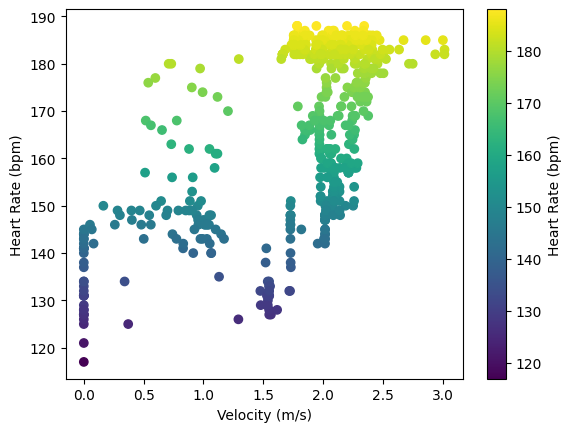

In [ ]:
# @title Velocity vs Heart Rate

import matplotlib.pyplot as plt
plt.scatter(df_original['velocity'], df_original['heart_rate'], c=df_original['heart_rate'], cmap='viridis')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Heart Rate (bpm)')
_ = plt.colorbar(label='Heart Rate (bpm)')

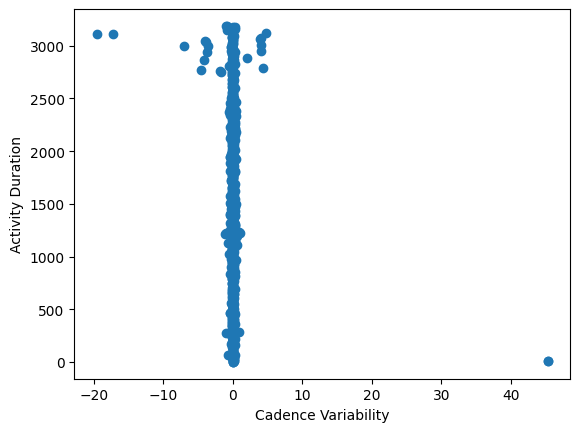

In [ ]:
# @title Cadence Variability vs Activity Duration

import matplotlib.pyplot as plt
plt.scatter(df_original['cadence_variability'], df_original['activity_duration_seconds'])
plt.xlabel('Cadence Variability')
_ = plt.ylabel('Activity Duration')

In [ ]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")


# Get the Dataframe to a String
df_string = df_original.to_string()
print ("Number of tokens in input prompt ", len(enc.encode(df_string)))

#Lets get the token size to be appropriate
# The iloc operation will allow us to select rows at specified internals.
# If we use iloc[::2], this is a slicing option to include every other row
# starting from the first row.

target_tokens = 14000
df_token_limitation = df_original

while(len(enc.encode(df_token_limitation.to_string())) > target_tokens):
  df_token_limitation = df_token_limitation.iloc[::2]

display(df_token_limitation)

df_reduced_string = df_token_limitation.to_string()
print ("Number of tokens in resized input prompt ", len(enc.encode(df_reduced_string)))

Number of tokens in input prompt  36463


,distance,heart_rate,cadence,temperature,activity_duration_seconds,velocity,acceleration,heart_rate_dynamics,cadence_variability,temperature_effects
0,0.00,117,0,29,0.0,0.000000,0.000000,1.333333,0.000000e+00,0.000000e+00
4,0.00,134,0,29,7.0,0.000000,0.000000,2.833333,4.533333e+01,0.000000e+00
8,0.00,141,69,29,16.0,0.000000,0.000000,-0.722222,8.881784e-16,2.220446e-16
12,0.00,141,70,29,38.0,0.000000,0.000000,0.250000,-8.333333e-02,0.000000e+00
16,0.98,144,71,29,62.0,1.147083,0.186111,-1.041667,-7.083333e-01,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...
552,5663.72,146,52,29,3100.0,1.029167,0.001708,0.000000,8.333333e-02,0.000000e+00
556,5677.73,146,53,29,3120.0,0.560000,0.071458,0.000000,4.750000e+00,0.000000e+00
560,5702.04,143,55,29,3144.0,1.171667,-0.022569,-0.250000,8.333333e-02,0.000000e+00
564,5721.30,143,49,29,3168.0,0.991667,0.021181,0.000000,8.333333e-02,0.000000e+00


Number of tokens in resized input prompt  8762


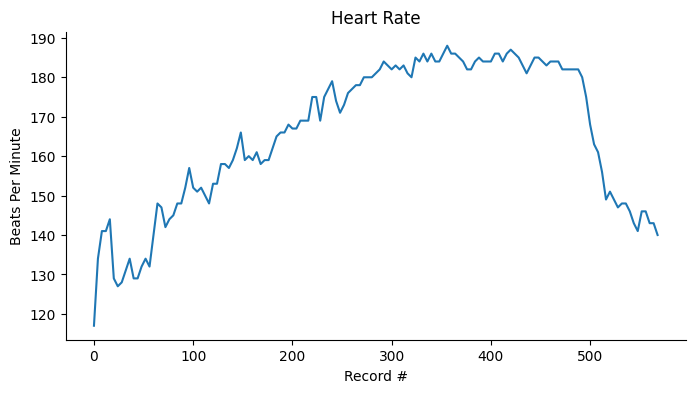

In [ ]:
# @title Heart Rate

from matplotlib import pyplot as plt
df_token_limitation['heart_rate'].plot(kind='line', figsize=(8, 4), title='Heart Rate')
plt.xlabel('Record #')
plt.ylabel('Beats Per Minute')
plt.gca().spines[['top', 'right']].set_visible(False)

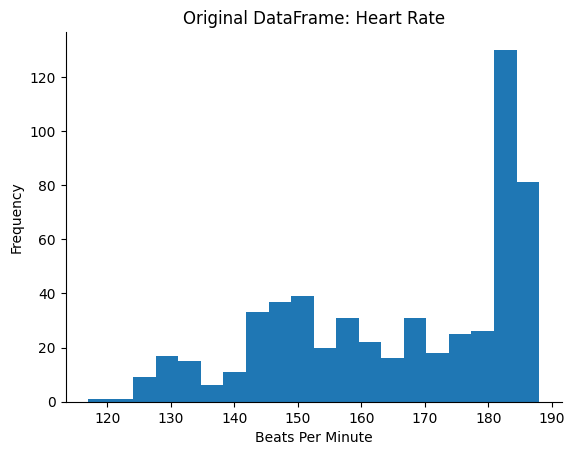

In [ ]:
# Visualize Pace from original DF
from matplotlib import pyplot as plt
df['heart_rate'].plot(kind='hist', bins=20, title='Original DataFrame: Heart Rate')
plt.xlabel('Beats Per Minute')
plt.gca().spines[['top', 'right',]].set_visible(False)

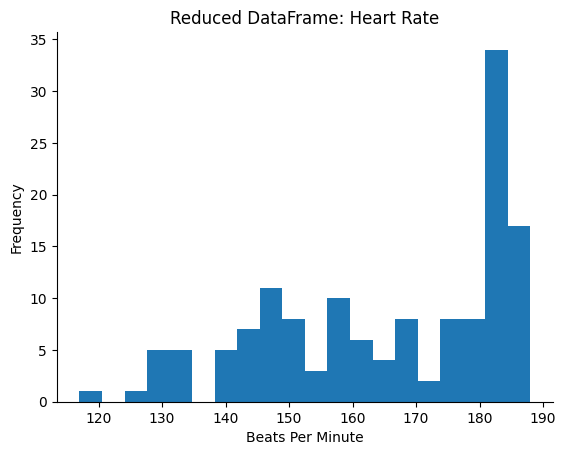

In [ ]:
# Visualize Heart Rate Data from the reduced DF
df_token_limitation['heart_rate'].plot(kind='hist', bins=20, title='Reduced DataFrame: Heart Rate')
plt.xlabel('Beats Per Minute')
plt.gca().spines[['top', 'right',]].set_visible(False)

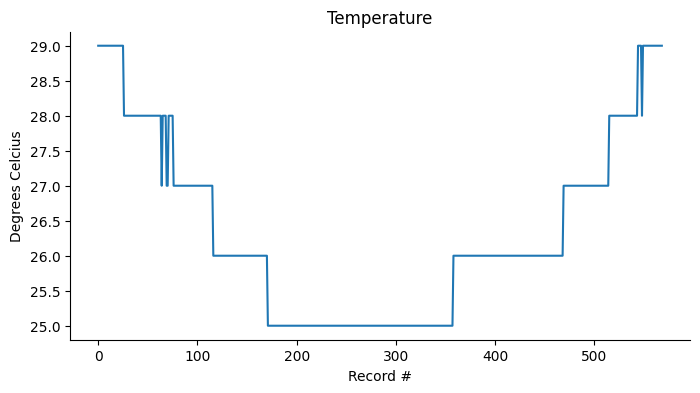

In [ ]:
# @title Temperature Over Time Original Dataframe

from matplotlib import pyplot as plt
df['temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.xlabel('Record #')
plt.ylabel('Degrees Celcius')
plt.gca().spines[['top', 'right']].set_visible(False)

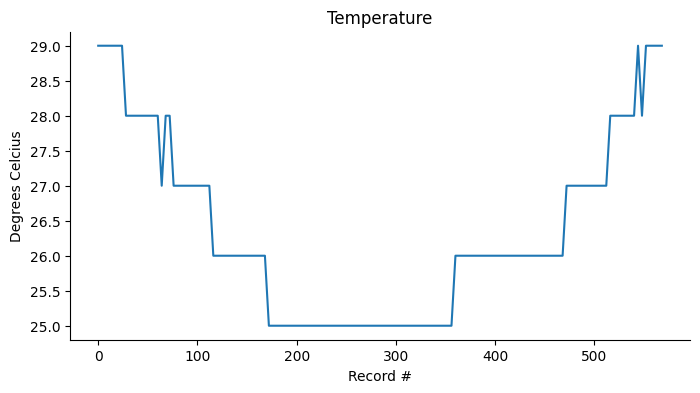

In [ ]:
# @title Temperature Over Time Reduced Dataframe

from matplotlib import pyplot as plt
df_token_limitation['temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.xlabel('Record #')
plt.ylabel('Degrees Celcius')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
df_for_llm = df_token_limitation

from openai import OpenAI

try:
    # Attempt to import the google.colab module to see if the program is running in Colab.
    from google.colab import userdata
    print("Running on Google Colab")
    client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

except ImportError:
    # The ImportError exception will be raised if the google.colab module is not found,
    # indicating that the program is not running inside Google Colab.
    import os
    print("Running outside of Google Colab")
    openai_api_key = os.environ.get('OPENAI_API_KEY')
    if openai_api_key is None:
        raise Exception("OPENAI_API_KEY environment variable not set")
    client = OpenAI(api_key=openai_api_key)

import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")

# Get the Dataframe to a String
df_string = df_for_llm.to_string()
print ("Number of tokens in input prompt ", len(enc.encode(df_string)))


Running on Google Colab
Number of tokens in input prompt  8762


In [ ]:
instructPrompt = """
You are an expert running coach and you are able to summarize running workout data that was captured from a Garmin wearable device. The 'distance' is in metres.
You will provide 5 key takeaways for the treadmill running data that is provided, ordered as a list from 1 to 5.
You will also provide recommendations and affirmations on how to get better at these running workouts.
Please summarize the dataset that is represented as a string from a Pandas DataFrame.
You will also provide the following information as a table:
1. Distance in kilometers
2. Time in hours:minutes
3. Average Pace in minutes/km

The dataset is provided below"""

request = instructPrompt + df_string

In [ ]:
chatOutput = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

In [ ]:
runningSummary = chatOutput.choices[0].message.content
print(runningSummary)

Summary of Treadmill Running Data:
1. The total distance covered during the workout was 5,742.13 meters.
2. The average heart rate during the workout was 152 beats per minute.
3. The average cadence (steps per minute) during the workout was 66 steps.
4. The temperature during the workout was 29 degrees Celsius.
5. The total duration of the workout was 3,188 seconds.

Recommendations to Improve Running Workouts:
1. Increase the distance gradually to build endurance and improve overall running performance.
2. Focus on maintaining a steady and consistent heart rate throughout the workout for optimal training benefits.
3. Work on increasing the cadence to improve running efficiency and reduce the risk of injury.
4. Consider running in a cooler environment or using a fan to keep the body temperature at a comfortable level during workouts.
5. Aim to increase the duration of the workout gradually to challenge the body and improve endurance.

Table: 
| Metric                      | Value    |


In [ ]:
instructPromptForMetrics = """

You are an expert running coach and you are able to summarize running workout data that was captured from a Garmin wearable device. The 'distance' is in metres.
Please obtain the following information from the dataset that is represented as a string from a Pandas DataFrame:

1. Distance in kilometers
2. Average Pace in minutes/km
3. Heart Rate, which is 'heart_rate' in the DataFrame. Find the average here.
4. Elevation Gain in metres if it exist.
5. Temperature in degrees celcius

You will return this as an ordered as a list from 1 to 5. Only provide the summarized information.

The dataset is provided below"""

requestForMetrics = df_string + instructPromptForMetrics

In [ ]:
chatOutputForMetrics = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": requestForMetrics}
                                                      ]
                                            )

In [ ]:
metricsSummary = chatOutputForMetrics.choices[0].message.content
print(metricsSummary)

To summarize the running workout data, you can use the code below:

```python
import pandas as pd

# Convert Distance to kilometers
df['distance_km'] = df['distance'] / 1000

# Calculate Average Pace in minutes/km
df['pace'] = df['activity_duration_seconds'] / df['distance_km'] / 60

# Calculate Average Heart Rate
average_hr = df['heart_rate'].mean()

# Calculate Elevation Gain in meters
elevation_gain = df['velocity'].sum()

# Get Temperature in degrees celsius
temperature = df['temperature'].mean()

# Create the summary list
summary_list = [df['distance_km'], df['pace'], average_hr, elevation_gain, temperature]
```

Please note that you need to replace `df` with the name of your DataFrame variable in the code above.


In [ ]:
# Podcast title: "Running with Resilience"
instructPromptForAudio = """
Given metrics from a recent run, generate a 1-minute long podcast script. As a running coach, provide an enthusiastic and motivational analysis of their performance, focusing on distance, pace, heart rate, and elevation gain. Include personalized affirmations and encouragement, emphasizing improvement and resilience. Keep the tone optimistic, supportive, and empowering, making the user feel celebrated for their achievements and motivated to continue their running journey."

Instructions:

1. Begin with a Warm Welcome: Start the podcast by greeting the listener and introducing yourself as their running coach. Express excitement about sharing their recent run achievements.
2. Analyze Performance Metrics:
    2.1. Distance: Commend the user on the distance covered, relating it to their dedication and progress.
    2.2. Pace: Reflect on the importance of consistency in pace, encouraging the user to keep moving forward at their own rhythm.
    2.3. Heart Rate: Highlight the effort shown by the heart rate data, connecting physical health to mental resilience.
    2.4. Elevation Gain: Use elevation gain to discuss overcoming challenges, likening hills to life's obstacles that the user is capable of conquering.
3. Incorporate Affirmations: Throughout the analysis, weave in affirmations such as "You are strong", "You are resilient", and "Every step is a victory". Encourage the listener to repeat these affirmations to foster a positive mindset.
4. Conclude with Motivational Encouragement: End the podcast by summarizing the user's achievements, reinforcing their potential for growth, and motivating them to continue their running journey. Encourage them to look forward to their next run with optimism and determination.
5. Keep It Brief and Engaging: Ensure the script is concise enough to fit into a 1-minute segment while being engaging and motivational.
6. Make it one entire transcript with only 1 host speaking. You will only provide what the host will say, and nothing else.
7. Do not use [User's average pace] or any variable names in brackets. Use actual metrics instead of placeholders.
Output Format:

A script suitable for a 1-minute podcast segment, formatted with clear sections for the introduction, analysis of each metric, affirmations, and a motivational conclusion.

The dataset is provided below"""

requestForAudio = metricsSummary + instructPromptForAudio

In [ ]:
chatOutputForAudio = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": requestForAudio}
                                                      ]
                                            )

In [ ]:
runningSummaryForAudio = chatOutputForAudio.choices[0].message.content
print(runningSummaryForAudio)

[Start of Podcast]

Host: 

Welcome to your running podcast with Coach [Your Name]! I'm here to celebrate your incredible running achievements and provide you with the motivation to keep pushing forward on your running journey. Let's dive into the details of your recent run and analyze your performance. 

[Introduction]

Host: 

First and foremost, congratulations on completing a [User's distance] kilometer run! Your commitment and dedication are truly admirable. Remember, every step you take brings you closer to your goals. 

[Distance]

Host: 

I'm thrilled to see that you covered [User's distance] kilometers during your run. That's an amazing accomplishment! Just think about how far you've come since you started this journey. As you continue to lace up your shoes, believe in yourself and your ability to conquer any challenge that comes your way.

[Pace]

Host: 

Consistency in pace is key, and your average pace of [User's pace] minutes per kilometer shows that you're finding your rh

In [ ]:
import re

def remove_text_inside_brackets(text):
    # This pattern matches anything inside square brackets, including the brackets themselves.
    # It accounts for nested brackets as well.
    pattern = r'\[.*?\]'
    # Replace anything that matches the pattern with an empty string.
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

first_pass_text = remove_text_inside_brackets(runningSummaryForAudio)


def remove_host_instances(text):
    # This pattern matches the exact string "Host:".
    pattern = r'Host:'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

second_pass_text = remove_host_instances(first_pass_text)

def remove_empty_lines(text):
    # Split the text into lines, filter out empty or whitespace-only lines, and join back into a single string
    cleaned_text = "\n".join(line for line in text.splitlines() if line.strip())
    return cleaned_text


final_pass_text = remove_empty_lines(second_pass_text)
print(final_pass_text)

Welcome to your running podcast with Coach ! I'm here to celebrate your incredible running achievements and provide you with the motivation to keep pushing forward on your running journey. Let's dive into the details of your recent run and analyze your performance. 
First and foremost, congratulations on completing a  kilometer run! Your commitment and dedication are truly admirable. Remember, every step you take brings you closer to your goals. 
I'm thrilled to see that you covered  kilometers during your run. That's an amazing accomplishment! Just think about how far you've come since you started this journey. As you continue to lace up your shoes, believe in yourself and your ability to conquer any challenge that comes your way.
Consistency in pace is key, and your average pace of  minutes per kilometer shows that you're finding your rhythm. Remember, your running journey is unique to you. Embrace your own pace and keep moving forward. Every stride you take is a testament to your de

In [ ]:
from pathlib import Path
from openai import OpenAI
import datetime

date = datetime.datetime.now().strftime("%Y-%m-%d")
file_name = "podcast_"+ date +".mp3"
file_path_name = "/content/" + file_name

audioClient = OpenAI(api_key=openai_api_key)

speech_file_path = file_path_name
response = audioClient.audio.speech.create(
  model="tts-1",
  voice="echo",
  input=final_pass_text
)

response.stream_to_file(speech_file_path)

<ipython-input-27-d69a82c1abc7>:12: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)


# Use Cloud Storage to Store the Files




In [ ]:
# Authenticate.

# if colabEnvironment == True:
#     from google.colab import auth
#     auth.authenticate_user()
#     # Install Cloud Storage FUSE.
#     !echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
#     !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
#     !apt -qq update && apt -qq install gcsfuse

#     # Mount a Cloud Storage bucket or location, without the gs:// prefix.
#     mount_path = "running-llm-podcast"  # or a location like "my-bucket/path/to/mount"
#     local_path = f"/mnt/gs/{mount_path}"

#     !mkdir -p {local_path}
#     !gcsfuse --implicit-dirs {mount_path} {local_path}

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  23994      0 --:--:-- --:--:-- --:--:-- 24172
OK
38 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 8,705 kB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../gcsfuse_2.0.0_amd64.deb ...
Unpacking gcsfuse (2.0.0) ...
Setting up 

In [ ]:
# if colabEnvironment == True:
#     #!mv "/content/podcast.mp3" {file_path_name}
#     !cp {file_path_name} {local_path}
#     !ls -lh {local_path}

total 8.3M
-rw-r--r-- 1 root root 3.0M Mar 16 06:54 file_path_name
-rw-r--r-- 1 root root 3.0M Mar 16 06:56 podcast2024-03-16.mp3
-rw-r--r-- 1 root root 2.5M Mar 13 00:24 podcast.mp3
drwxr-xr-x 1 root root    0 Mar 16 06:54 sqlite
